In [1]:
from dotenv import load_dotenv

load_dotenv()

True

In [2]:
from typing import Annotated, Literal, TypedDict
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage

class ChatMessages(TypedDict):
    messages: list[BaseMessage]

In [3]:
from langgraph.graph import END, START, StateGraph, MessagesState
from langchain_openai import ChatOpenAI
from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode

In [4]:
@tool
def get_weather(location: str):
    """Call to get the current weather."""
    if location.lower() in ["munich"]:
        return "It's 15 degrees Celsius and cloudy."
    else:
        return "It's 32 degrees Celsius and sunny."

In [5]:
get_weather.invoke(input={"location": "munich"})

"It's 15 degrees Celsius and cloudy."

In [6]:
tools=[get_weather]
model = ChatOpenAI(model="gpt-4o-mini").bind_tools(tools)

In [7]:
model.invoke("hello")

AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 45, 'total_tokens': 55, 'completion_tokens_details': {'audio_tokens': None, 'reasoning_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_482c22a7bc', 'finish_reason': 'stop', 'logprobs': None}, id='run-600c49ea-6ef7-4f1e-8056-8ba8b8e19fd2-0', usage_metadata={'input_tokens': 45, 'output_tokens': 10, 'total_tokens': 55, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 0}})

In [8]:
model.invoke("How is the weather in munich?")

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_2VaZmBkskT4FkOaqU0cTCX9E', 'function': {'arguments': '{"location":"Munich"}', 'name': 'get_weather'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 15, 'prompt_tokens': 52, 'total_tokens': 67, 'completion_tokens_details': {'audio_tokens': None, 'reasoning_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_482c22a7bc', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-e91e3119-08c4-4188-8abd-86c5c0f1e97c-0', tool_calls=[{'name': 'get_weather', 'args': {'location': 'Munich'}, 'id': 'call_2VaZmBkskT4FkOaqU0cTCX9E', 'type': 'tool_call'}], usage_metadata={'input_tokens': 52, 'output_tokens': 15, 'total_tokens': 67, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 0}})

In [9]:
def call_model(state: MessagesState):
    messages = state['messages']
    response = model.invoke(messages)
    return {"messages": [response]}


def should_continue(state: MessagesState) -> Literal["tools", END]:
    messages = state['messages']
    last_message = messages[-1]
    if last_message.tool_calls:
        return "tools"
    return END

In [10]:
workflow = StateGraph(MessagesState)
tool_node = ToolNode(tools)

workflow.add_node("agent", call_model)
workflow.add_node("tools", tool_node)

In [11]:
workflow.add_edge(START, "agent")

workflow.add_conditional_edges(
    "agent",
    should_continue,
)
workflow.add_edge("tools", 'agent')

In [12]:
graph = workflow.compile()

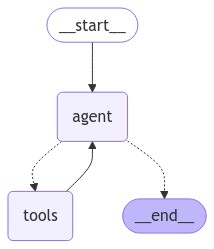

In [13]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [14]:
messages1 = [HumanMessage(content="Hello, how are you?")]
messages2 = [HumanMessage(content="How is the weather in munich?")]

In [15]:
graph.invoke({"messages": messages1})

{'messages': [HumanMessage(content='Hello, how are you?', additional_kwargs={}, response_metadata={}, id='fa8134ec-5a6c-4255-8ea8-3971605c55d2'),
  AIMessage(content="I'm just a computer program, so I don't have feelings, but I'm here and ready to help you! How can I assist you today?", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 29, 'prompt_tokens': 50, 'total_tokens': 79, 'completion_tokens_details': {'audio_tokens': None, 'reasoning_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_e2bde53e6e', 'finish_reason': 'stop', 'logprobs': None}, id='run-f1539660-bb8c-48d8-95c1-9605cb347c01-0', usage_metadata={'input_tokens': 50, 'output_tokens': 29, 'total_tokens': 79, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 0}})]}

In [16]:
graph.invoke({"messages": messages2})

{'messages': [HumanMessage(content='How is the weather in munich?', additional_kwargs={}, response_metadata={}, id='193ba3bb-eea2-48a7-961d-207c521ac9fe'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_kerGPvuKT6fX5bMMGTfxgRfH', 'function': {'arguments': '{"location":"Munich"}', 'name': 'get_weather'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 15, 'prompt_tokens': 52, 'total_tokens': 67, 'completion_tokens_details': {'audio_tokens': None, 'reasoning_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_482c22a7bc', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-dd3bd7d5-6141-44b2-9f3b-7f9a505677a1-0', tool_calls=[{'name': 'get_weather', 'args': {'location': 'Munich'}, 'id': 'call_kerGPvuKT6fX5bMMGTfxgRfH', 'type': 'tool_call'}], usage_metadata={'input_tokens': 52, 'output_tokens': 15, 'total_tokens': 67,

In [17]:
graph.invoke(
    {"messages": [HumanMessage(content="What would you recommend to do in that city than?")]}
)

{'messages': [HumanMessage(content='What would you recommend to do in that city than?', additional_kwargs={}, response_metadata={}, id='5082334a-79b4-4687-9b95-7d397c09a69c'),
  AIMessage(content="Could you please specify which city you're referring to?", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 11, 'prompt_tokens': 55, 'total_tokens': 66, 'completion_tokens_details': {'audio_tokens': None, 'reasoning_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_482c22a7bc', 'finish_reason': 'stop', 'logprobs': None}, id='run-8ab484cc-d3c4-4a21-a30f-56281912f725-0', usage_metadata={'input_tokens': 55, 'output_tokens': 11, 'total_tokens': 66, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 0}})]}

### Add Memory to chatbot

In [18]:
from langgraph.checkpoint.memory import MemorySaver

checkpointer = MemorySaver()

In [20]:
workflow = StateGraph(MessagesState)

workflow.add_node("agent", call_model)
workflow.add_node("tools", tool_node)

workflow.add_edge(START, "agent")

workflow.add_conditional_edges(
    "agent",
    should_continue,
)
workflow.add_edge("tools", 'agent')

graph = workflow.compile(checkpointer=checkpointer)

ValueError: Too many arguments for tool decorator

In [ ]:
graph.invoke(
    {"messages": [HumanMessage(content="How is the weather in munich?")]},
    config={"configurable": {"thread_id": 1}}
)

In [ ]:
graph.invoke(
    {"messages": [HumanMessage(content="What would you recommend to do in that city than?")]},
    config={"configurable": {"thread_id": 1}}
)